# "Segmentez des clients d'un site e-commerce"
_Cleaning Notebook_

## 0 Preliminaries

In [1]:
# !pip install flake8 pycodestyle_magic
# !pip install gtts
# !pip install category-encoders
# !pip install mlxtend==0.17.3 # makes Google Colab asking for reboot
# !pip install ppscore

In [2]:
# !pip freeze > requirements_cleaning_eda.txt

Checking for PEP8 compliance

In [3]:
# %load_ext pycodestyle_magic
# %pycodestyle_on
# %pycodestyle_off

### 0.0 Importing Packages and Modules

Checking whether the notebook is on Colab or PC

In [4]:
import sys
is_colab = 'google.colab' in sys.modules
is_colab, sys.executable

(True, '/usr/bin/python3')

Mounting my Drive if on colab

In [5]:
if is_colab==True:
    from google.colab import files, output, drive
    drive.mount('/gdrive')
    %cd /gdrive
    print("You're on Google Colab")
else:
    print("You're on a PC")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive
You're on Google Colab


Installations and importations required in the virtual environment.

In [7]:
import os
if is_colab==True:
    if os.getcwd()!='/gdrive/My Drive/--DATA SCIENCE/PROJET5/NOTEBOOKS':
        os.chdir('My Drive/--DATA SCIENCE/PROJET5/NOTEBOOKS')
else:
    if not (os.path.exists(os.getcwd()+'/requirements_cleaning_eda.txt') \
                     and os.path.exists(os.getcwd()+'/P5_functions.py')):
        print("ERROR: Make sure 'P5_functions.py' and 'requirements_cleaning_eda.txt' are in the current working directory")

!pip install -r requirements_cleaning_eda.txt
from P5_functions import *

     |████████████████████████████████| 81kB 2.1MB/s 
     |████████████████████████████████| 81kB 7.4MB/s 
     |████████████████████████████████| 1.3MB 35.4MB/s 
     |████████████████████████████████| 51kB 6.7MB/s 
     |████████████████████████████████| 71kB 8.8MB/s 
  Created wheel for gTTS-token: filename=gTTS_token-1.1.3-cp36-none-any.whl size=4096 sha256=1d34e31b15730f15c91eac8f5f44095e18a49484911718031b79f2e60575bd55
  Stored in directory: /root/.cache/pip/wheels/dd/11/61/33f7e51bf545e910552b2255eead2a7cd8ef54064b46dceb34
  Created wheel for ppscore: filename=ppscore-1.1.1-py2.py3-none-any.whl size=12987 sha256=d6c2b20077a24f0b19c932ffba576eb2c1c69daae8e28e145c9af28ea6cf4082
  Stored in directory: /root/.cache/pip/wheels/3a/16/cb/4768ae3fd9f02af8cd6d880b9095281cc62bb1748fac67fdc4
Successfully built gTTS-token ppscore
  Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Importation of modules and packages. 

In [8]:
import io

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.facecolor']='w'

import missingno as msno
import ppscore as pps

import dill

Setting pandas display options

In [9]:
dictPdSettings = {'display.max_rows': 500, 'display.width': 100,
                    'display.max_colwidth': 100,
                    'display.float_format': lambda x: '%.2f' % x}
for k,v in dictPdSettings.items():
  pd.set_option(k,v)

To play audio text-to-speech during execution.

In [10]:
from IPython.display import Audio
from gtts import gTTS

def speak(text, lang='en'):
    with io.BytesIO() as f:
        gTTS(text=text, lang=lang).write_to_fp(f)
        f.seek(0)
        return Audio(f.read(), autoplay=True)

In [11]:
speak('Packages and modules successfully imported')

### 0.1 Importing the Aggregated Orders dataset

Data is composed of 9 distinct .csv files, that we'll load in a dictionnary of dataframes.

In [13]:
# from datetime import strptime

if is_colab==True:
    # Importing database from my Drive
    print("Try to import data files in the notebook from myDrive...")
else:
    # Importing database from PC
    print("Try to import data files in the notebook from PC ('DATA')...")

df_cust = pd.read_csv('agg_customers.csv', sep=',', index_col='customer_unique_id',
                        encoding ='utf-8').drop(columns=['Unnamed: 0'])

df_orders = pd.read_csv('agg_orders.csv', sep=',', index_col='order_id',
                        encoding ='utf-8').drop(columns=['Unnamed: 0'])

print("-----> Importation of .csv in the notebook: OK")

Try to import data files in the notebook from myDrive...
-----> Importation of .csv in the notebook: OK


All the dates and timestamps in the dataframes are to be converted.

In [16]:
df_orders.columns, df_cust.columns

(Index(['customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state',
        'order_status', 'order_purchase_timestamp', 'shipping_time', 'shipping_delay', 'delivered',
        'price', 'freight_value', 'order_item_nb', 'max_limit_ship_date', 'mean_prod_descr_length',
        'review_score', 'review_comment_length', 'cum_paytype', 'paytype_boleto',
        'paytype_credit_card', 'paytype_debit_card', 'paytype_not_defined', 'paytype_voucher',
        'payment_installments', 'payment_value', 'main_prod_categ', 'cat_office', 'cat_unknown',
        'cat_fashion', 'cat_furniture', 'cat_hygiene', 'cat_home', 'cat_leisure', 'cat_diy',
        'cat_multimedia', 'cat_food', 'cat_electronics', 'cat_books', 'cat_miscellaneous'],
       dtype='object'),
 Index(['cust_city', 'cust_zipcode', 'cust_state', 'mean_nb_items_per_ord', 'tot_nb_items',
        'mean_freight_val_per_order', 'tot_freight_val', 'mean_price_per_order',
        'avg_freight_payval_ratio', 'tot_price', 't

In [27]:
df_orders.select_dtypes(include=['object']).columns#.value_counts(),
# df_cust.dtypes#.value_counts()

Index(['customer_unique_id', 'customer_city', 'customer_state', 'order_status',
       'order_purchase_timestamp', 'shipping_time', 'shipping_delay', 'max_limit_ship_date',
       'cum_paytype', 'main_prod_categ'],
      dtype='object')

In [ ]:
df_cust[['order_purchase_timestamp', 'max_limit_ship_date']] = \
    df_cust[['order_purchase_timestamp', 'max_limit_ship_date']]\
        .apply(lambda x: pd.to_datetime(x))

df_cust[['shipping_time', 'shipping_delay']] = \
    df_cust[['shipping_time', 'shipping_delay']]\
        .apply(lambda x: pd.to_timedelta(x))  

df_cust['customer_zip_code_prefix'] = \
    df_cust['customer_zip_code_prefix'].astype('object')

In [ ]:
df_cust.dtypes

In [ ]:
speak('Dataset successfully imported')

### 0.2 Aggregation of the cutomers dataset on custom time slots 

In [ ]:
# Aggregation in a chosen time slot
# all customers (for max period of time): (96095, 22)

# t_min = pd.Timestamp('2017-10-17 17:30:18')
# t_max = pd.Timestamp('2018-01-01 17:30:18')

def generate_cust_df(df_orders, t_min=None, t_max=None):
    df_cust = create_agg_cust_df(df_orders)
    df_cust = create_features_cust_df(df_cust)
    return df_cust

## 1 Clustering

In [ ]:
df_cust.columns

In [ ]:
tdelta_cols = ['time_since_last_purch', 'time_since_first_purch',
               'mean_ship_time', 'mean_ship_delay']
df_cust[tdelta_cols] = df_cust[tdelta_cols].apply(lambda x: x.dt.days)

In [ ]:
df_cust.head(5)

,cust_zipcode,cust_city,cust_state,tot_nb_ord,tot_nb_deliv_ord,time_since_last_purch,time_since_first_purch,mean_ship_time,mean_ship_delay,tot_nb_items,mean_nb_items_per_ord,mean_prod_descr_length,mean_price,mean_freight_val,mean_pay_value,tot_price,tot_freight_val,tot_pay_value,mean_pay_install,mean_rev_score,mean_comment_length,tot_comment_length
customer_unique_id,,,,,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,7787,cajamar,SP,1,1,160,160,6,6,1.00,1.00,236.00,129.90,12.00,141.90,129.90,12.00,141.90,8.00,5.00,111.00,111.00
0000b849f77a49e4a4ce2b2a4ca5be3f,6053,osasco,SP,1,1,163,163,3,3,1.00,1.00,635.00,18.90,8.29,27.19,18.90,8.29,27.19,1.00,4.00,0.00,0.00
0000f46a3911fa3c0805444483337064,88115,sao jose,SC,1,1,585,585,25,25,1.00,1.00,177.00,69.00,17.22,86.22,69.00,17.22,86.22,8.00,3.00,0.00,0.00
0000f6ccb0745a6a4b88665a16c9f078,66812,belem,PA,1,1,369,369,20,20,1.00,1.00,1741.00,25.99,17.63,43.62,25.99,17.63,43.62,4.00,4.00,12.00,12.00
0004aac84e0df4da2b147fca70cf8255,18040,sorocaba,SP,1,1,336,336,13,13,1.00,1.00,794.00,180.00,16.89,196.89,180.00,16.89,196.89,6.00,5.00,0.00,0.00


In [ ]:
df_cust.dtypes

In [ ]:
df_cust.select_dtypes(include=['object']).nunique()

cust_zipcode    14981
cust_city        4119
cust_state         27
dtype: int64

In [ ]:
# Transformation and encoding

ct = CustTransformer(strat_high_card='ord', strat_quant = 'stand')
ct.fit(df_cust)
df_cust_trans = ct.transform(df_cust)

In [ ]:
df_cust_trans.columns

In [ ]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=300)
km.fit(df_cust_trans)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=300, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
ser = km.labels_

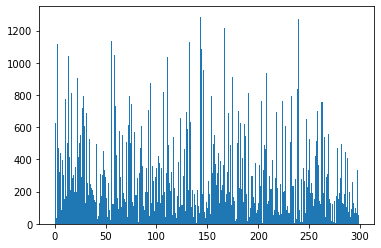

In [ ]:
# homogénéité des clusters
plt.hist(ser, bins=300);